In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Dropout,Flatten,MaxPooling2D,BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import np_utils

In [2]:
# Use pandas to read and load csv file, print its infomation
Data=pd.read_csv('merge_data.csv') # merge_data is merged by 2 emotion datasets, has more samples
# Check data infomation, searching missing value
print(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  71769 non-null  int64 
 1   pixels   71769 non-null  object
 2   Usage    71769 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB
None


In [3]:
# Print counts of data value in column 'Usage'
print(Data['Usage'].value_counts())

Training    57414
Test        14355
Name: Usage, dtype: int64


In [7]:
# Show data detailed infomarion
print(Data)

       emotion                                             pixels     Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
...        ...                                                ...       ...
71764        0  25 21 21 18 30 102 144 147 150 161 179 179 178...      Test
71765        0  117 115 96 99 141 160 165 175 182 179 185 193 ...      Test
71766        5  184 178 153 83 83 106 93 81 102 103 82 119 111...      Test
71767        2  205 219 122 42 55 56 58 57 81 90 81 93 111 120...      Test
71768        6  216 154 144 220 233 220 213 208 204 200 196 19...      Test

[71769 rows x 3 columns]


In [5]:
Data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
71764,0,25 21 21 18 30 102 144 147 150 161 179 179 178...,Test
71765,0,117 115 96 99 141 160 165 175 182 179 185 193 ...,Test
71766,5,184 178 153 83 83 106 93 81 102 103 82 119 111...,Test
71767,2,205 219 122 42 55 56 58 57 81 90 81 93 111 120...,Test


In [8]:
# Construct new array for train and test set
X_train,Y_train,X_test,Y_test=[],[],[],[]

In [9]:
# Split the data by specifying space and return the split list iteratively. The data in this column is pixel information
for index,row in Data.iterrows():
    val=row['pixels'].split(' ')
    # Trt except to catch error
    # Catching and adding data to array
    try:
        if 'Training' in row['Usage']:
            X_train.append(np.array(val,'float32'))
            Y_train.append(row['emotion'])
        elif 'Test' in row['Usage']:
            X_test.append(np.array(val,'float32'))
            Y_test.append(row['emotion'])
    except:
        pass

In [10]:
# Transfer Data set into Keras form
X_train = np.array(X_train,'float32')
Y_train = np.array(Y_train,'float32')
X_test = np.array(X_test,'float32')
Y_test = np.array(Y_test,'float32')

In [11]:
# Data preprocessing
# Carry out data standardization, mean value processing and standard deviation correction
X_train -= np.mean(X_train,axis=0) # Calculate the mean value of each column
X_train /= np.std(X_train,axis=0) # Calculate the standard deviation of each column

X_test -= np.mean(X_test,axis=0) # Calculate the mean value of each column
X_test /= np.std(X_test,axis=0) # Calculate the standard deviation of each column

In [12]:
# Convert labels to one-hot encoding
labels = 7 # There are 7 emotions will be output
# One-hot encoding conversion for data labels
Y_train = np_utils.to_categorical(Y_train,num_classes=labels)
Y_test = np_utils.to_categorical(Y_test,num_classes=labels)

In [13]:
filters = 64 # Number of filters for convolution
batch_size = 256
epochs = 20
width,height = 48,48 # Pictures' pixels size: 48*48

In [14]:
# Generate new list, modify data
X_train = X_train.reshape(X_train.shape[0],width,height,1) # Give the array a new shape without changing the data
X_test = X_test.reshape(X_test.shape[0],width,height,1) # The elements are changed into several small matrices of 48*48

In [15]:
# Build CNN
"""
Convolution takes local features.
The function of the convolution layer
is to determine the valuable convolution kernels of the features of the picture 
by constantly changing the convolution kernels and then
multiplying them with the corresponding convolution kernels to obtain the matrix
Max-pooling is to extract several features from a filter
only the max pooling layer is obtained as the reserved value, and all other weak values are discarded
"""
# 1st layer
model = Sequential()
model.add(Conv2D(filters, kernel_size=(3, 3),activation='relu',input_shape=(X_train.shape[1:])))
model.add(BatchNormalization())
model.add(Conv2D(filters, kernel_size=(3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25)) # Reduce the over fitting, because it will not rely too much on some local features, making the model more generalized

# 2nd layer
'''
In the process of downsampling, the number of filters increases,
which seems to better summarize the high-level features
and make up for the loss of information caused by the decline of resolution,
so increase filters number
'''
model.add(Conv2D(2*filters, kernel_size=(3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(2*filters, kernel_size=(3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

# 3rd layer
model.add(Conv2D(4*filters, kernel_size=(3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(4*filters, kernel_size=(3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(2*2*2*2*filters,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(labels,activation='softmax'))
# Summary and print model information and parameter
model.summary()
# Define loss function, optimizer, and calculate accuracy
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       7

In [16]:
# History records the changes of loss function and other indicators with epoch
# It also includes the changes of these indicators in the verification set
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test,Y_test),
          shuffle=True)

Epoch 1/20
225/225 [==============================] - 628s 3s/step - loss: 1.7784 - accuracy: 0.3508 - val_loss: 2.0237 - val_accuracy: 0.2458
Epoch 2/20
225/225 [==============================] - 646s 3s/step - loss: 1.2192 - accuracy: 0.5385 - val_loss: 1.4579 - val_accuracy: 0.4582
Epoch 3/20
225/225 [==============================] - 600s 3s/step - loss: 0.9833 - accuracy: 0.6293 - val_loss: 0.9880 - val_accuracy: 0.6311
Epoch 4/20
225/225 [==============================] - 601s 3s/step - loss: 0.8123 - accuracy: 0.6984 - val_loss: 0.8103 - val_accuracy: 0.7037
Epoch 5/20
225/225 [==============================] - 611s 3s/step - loss: 0.6490 - accuracy: 0.7655 - val_loss: 0.6975 - val_accuracy: 0.7540
Epoch 6/20
225/225 [==============================] - 580s 3s/step - loss: 0.4947 - accuracy: 0.8261 - val_loss: 0.6661 - val_accuracy: 0.7821
Epoch 7/20
225/225 [==============================] - 570s 3s/step - loss: 0.3829 - accuracy: 0.8673 - val_loss: 0.5848 - val_accuracy: 0.8223

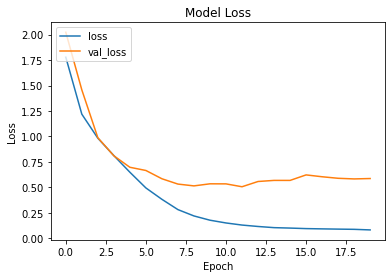

In [17]:
# The highest accuracy rate of the previous presentation is close to 60%.
# With the addition of data sets, the accuracy rate has been greatly improved.
# The result of 20 training times is close to 90%. This is our progress
import matplotlib.pyplot as plt
# Plot loss of the history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

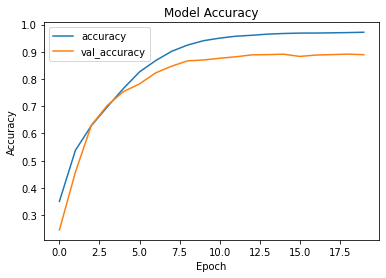

In [18]:
# Plot accuracy of the history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

In [19]:
# Save the model are saved, including model weights and graph structure
model.save('final_emotion_model.hdf5')